# Insights from NWSL 2023: Player Stats and Team Success

I'm very interested in women's sports and would like to apply this course's learnings to an analysis of the National Women's Soccer League (NWSL). There are 2 data sets I'll use:
1) 2023 team rankings. I created this manually from the NWSL website https://www.nwslsoccer.com/standings/regular-season
2) 2023 player statistics. I found this on Kaggle. It sources from the same NWSL website. https://www.kaggle.com/datasets/brzy56/2023-nwsl-womens-soccer-league-player-stats-full. Unfortunately, it has little documentation or usage data, so it's risky.

**Goals of this analysis:**
1) Descriptive statistics of the top teams and top players
2) Model relationship between key statistics and team success
3) Cluster players
    
## Part 1: Data Loading and Cleaning

In [934]:
#load dataset 1 which is the 2023 team standings and key stats
import pandas as pd
pd.set_option('display.max_columns', None) #want to see all the columns even if it means scrolling
df_team = pd.read_csv('teamstats23.csv')

In [935]:
df_team

,Team,Home W-L-D,Away W-L-D,GF,GA
0,San Diego Wave FC,5/4/02,6/3/02,31,22
1,Portland Thorns,7/2/02,3/5/03,42,32
2,North Carolina Courage,5/1/05,4/6/01,29,22
3,Seattle Reign,6/2/03,3/6/02,29,24
4,Angel City FC,4/5/02,4/2/05,31,30
5,NJ/NY Gotham FC,4/3/04,4/4/03,25,24
6,Orlando Pride,7/4/00,3/7/01,27,28
7,Washington Spirit,4/3/04,3/3/05,26,29
8,Racing Louisville FC,5/2/04,1/5/05,25,24
9,Houston Dash,2/4/05,4/4/03,16,18


In [936]:
df_team.dtypes

Team          object
Home W-L-D    object
Away W-L-D    object
GF             int64
GA             int64
dtype: object

In [937]:
#data cleaning
#win loss draw did not properly load from the csv so let's clean it up
df_team['Home_Win']=df_team['Home W-L-D'].str[0].astype(int)
df_team['Home_Loss']=df_team['Home W-L-D'].str[2].astype(int)
df_team['Home_Draw']=df_team['Home W-L-D'].str[5].astype(int)
df_team['Away_Win']=df_team['Away W-L-D'].str[0].astype(int)
df_team['Away_Loss']=df_team['Away W-L-D'].str[2].astype(int)
df_team['Away_Draw']=df_team['Away W-L-D'].str[5].astype(int)
df_team.drop(['Home W-L-D', 'Away W-L-D'], axis=1, inplace=True) 
#add total win loss draw data
df_team['Total_Win']=df_team['Home_Win']+df_team['Away_Win']
df_team['Total_Loss']=df_team['Home_Loss']+df_team['Away_Loss']
df_team['Total_Draw']=df_team['Home_Draw']+df_team['Away_Draw']
#add point total win=3, draw=1; also add goal differential = GD
df_team['Points'] = 3*df_team['Total_Win']+df_team['Total_Draw']
df_team['GD']=df_team['GF']-df_team['GA']
#reorder columns for easier comprehension
df_team = df_team.reindex(columns=['Team', 'Points', 'GF', 'GA', 'GD', 'Total_Win', 'Total_Loss', 'Total_Draw','Home_Win','Home_Loss', 'Home_Draw','Away_Win','Away_Loss','Away_Draw'])
df_team

,Team,Points,GF,GA,GD,Total_Win,Total_Loss,Total_Draw,Home_Win,Home_Loss,Home_Draw,Away_Win,Away_Loss,Away_Draw
0,San Diego Wave FC,37,31,22,9,11,7,4,5,4,2,6,3,2
1,Portland Thorns,35,42,32,10,10,7,5,7,2,2,3,5,3
2,North Carolina Courage,33,29,22,7,9,7,6,5,1,5,4,6,1
3,Seattle Reign,32,29,24,5,9,8,5,6,2,3,3,6,2
4,Angel City FC,31,31,30,1,8,7,7,4,5,2,4,2,5
5,NJ/NY Gotham FC,31,25,24,1,8,7,7,4,3,4,4,4,3
6,Orlando Pride,31,27,28,-1,10,11,1,7,4,0,3,7,1
7,Washington Spirit,30,26,29,-3,7,6,9,4,3,4,3,3,5
8,Racing Louisville FC,27,25,24,1,6,7,9,5,2,4,1,5,5
9,Houston Dash,26,16,18,-2,6,8,8,2,4,5,4,4,3


In [938]:
#load dataset 2 which is the player statistics
df_player = pd.read_csv('2023_nwsl_full.csv')

In [939]:
#now take a look at the data to better understand it
df_player.head()

,team,player_name,conc_player_name,position,games_played,games_started,minutes_played,goals,accurate_pass_percentage,assists,assists_avg_over_90_mins,total_scoring_attempts,on_target_scoring_attempts,total_attacking_assists,tackles,fouls_committed,fouls_suffered,total_offside,yellow_cards,red_cards,goals_avg_over_90_mins,penalty_kick_goals,penalty_kick_taken,penalty_kick_percentage,accurate_shooting_percentage,successful_dribble,dribble_percentage,goals_and_assists,accurate_passes,total_passes,accurate_pass_percentage.1,crosses,accurate_long_balls,successful_short_passes,turnovers,tackles_percentage,interceptions,headed_duel,saves,penalty_kicks_conceded,long_ball_percentage,total_clearance
0,Orlando Pride,Kerry Abello,KERRYABELLO,DEFENDER,20,14.0,1256,1,79,0,0.00,22,12,0,25,20,10,1,1,0,0.07,0,0,0,55,23,58,1,326,413,79,4,14,308,200,64,7,19,NaN,NaN,NaN,NaN
1,Chicago Red Stars,Jillienne Cole Aguilera,JILLIENNE COLEAGUILERA,MIDFIELDER,11,1.0,176,0,62,0,0.00,4,0,0,0,2,2,0,0,0,0.00,0,0,0,0,0,0,0,47,76,62,1,1,45,46,0,2,2,NaN,NaN,NaN,NaN
2,San Diego Wave FC,Amirah Ali,AMIRAHALI,FORWARD,17,5.0,467,2,66,0,0.00,13,6,0,8,3,15,3,1,0,0.39,0,0,0,46,11,44,2,79,120,66,1,1,77,102,67,2,17,NaN,NaN,NaN,NaN
3,Orlando Pride,Amanda Allen,AMANDAALLEN,FORWARD,3,NaN,9,0,50,0,0.00,0,0,0,0,0,0,1,0,0,0.00,0,0,0,0,0,0,0,1,2,50,0,0,1,3,0,0,0,NaN,NaN,NaN,NaN
4,Houston Dash,Michelle Alozie,MICHELLEALOZIE,FORWARD,17,13.0,1013,4,67,1,0.09,23,9,1,8,15,14,3,1,1,0.36,0,0,0,39,17,42,5,140,210,67,3,7,130,210,73,6,32,NaN,NaN,NaN,NaN


In [940]:
#remove one duplicate column
df_player.drop(['accurate_pass_percentage.1'],axis=1, inplace=True)

In [941]:
df_player.dtypes

team                             object
player_name                      object
conc_player_name                 object
position                         object
games_played                      int64
games_started                   float64
minutes_played                    int64
goals                             int64
accurate_pass_percentage          int64
assists                           int64
assists_avg_over_90_mins        float64
total_scoring_attempts            int64
on_target_scoring_attempts        int64
total_attacking_assists           int64
tackles                           int64
fouls_committed                   int64
fouls_suffered                    int64
total_offside                     int64
yellow_cards                      int64
red_cards                         int64
goals_avg_over_90_mins          float64
penalty_kick_goals                int64
penalty_kick_taken                int64
penalty_kick_percentage           int64
accurate_shooting_percentage      int64


In [942]:
# looks like the percentages are mostly shown as ints but the 'per 90 min' stats are fractional floats
df_player.describe()

,games_played,games_started,minutes_played,goals,accurate_pass_percentage,assists,assists_avg_over_90_mins,total_scoring_attempts,on_target_scoring_attempts,total_attacking_assists,tackles,fouls_committed,fouls_suffered,total_offside,yellow_cards,red_cards,goals_avg_over_90_mins,penalty_kick_goals,penalty_kick_taken,penalty_kick_percentage,accurate_shooting_percentage,successful_dribble,dribble_percentage,goals_and_assists,accurate_passes,total_passes,crosses,accurate_long_balls,successful_short_passes,turnovers,tackles_percentage,interceptions,headed_duel,saves,penalty_kicks_conceded,long_ball_percentage,total_clearance
count,347.000000,267.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,38.000000,38.000000,38.000000,38.000000
mean,11.968300,11.307116,781.461095,0.965418,63.170029,0.657061,0.060893,7.472622,3.625360,0.657061,8.933718,8.141210,7.752161,1.458213,1.020173,0.040346,0.088040,0.100865,0.115274,5.285303,29.452450,7.221902,43.193084,1.622478,243.063401,318.749280,1.835735,17.668588,223.559078,123.069164,48.902017,7.766571,18.279539,23.868421,0.105263,25.815789,6.973684
std,7.990358,7.122140,674.031106,1.797224,26.713042,1.163250,0.114846,10.847670,5.975697,1.163250,9.862857,8.415867,9.732059,2.849878,1.333060,0.197053,0.151313,0.479251,0.525063,21.790168,29.511043,9.449885,31.315939,2.588070,260.806434,323.777903,3.275252,29.229157,241.558927,113.306663,31.985847,9.712053,20.705050,29.662216,0.311012,22.021924,8.480460
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,5.000000,139.000000,0.000000,64.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,33.000000,48.000000,0.000000,1.000000,29.000000,23.000000,8.500000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000
50%,13.000000,11.000000,633.000000,0.000000,72.000000,0.000000,0.000000,3.000000,1.000000,0.000000,6.000000,6.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,29.000000,3.000000,50.000000,0.000000,153.000000,224.000000,0.000000,6.000000,144.000000,95.000000,58.000000,4.000000,11.000000,8.000000,0.000000,35.000000,3.000000
75%,20.000000,18.000000,1375.500000,1.000000,79.000000,1.000000,0.090000,10.000000,5.000000,1.000000,14.000000,13.000000,11.000000,2.000000,2.000000,0.000000,0.140000,0.000000,0.000000,0.000000,50.000000,10.500000,64.000000,2.000000,379.000000,500.000000,2.000000,21.000000,336.500000,194.500000,70.500000,12.000000,27.000000,45.000000,0.000000,43.750000,13.000000
max,26.000000,25.000000,2199.000000,11.000000,112.000000,8.000000,0.780000,67.000000,39.000000,8.000000,46.000000,38.000000,67.000000,19.000000,6.000000,1.000000,1.060000,5.000000,5.000000,100.000000,100.000000,67.000000,100.000000,16.000000,1413.000000,1703.000000,22.000000,226.000000,1320.000000,485.000000,100.000000,45.000000,125.000000,91.000000,1.000000,60.000000,29.000000


In [943]:
#the regular season is 22 games so let me take a look at players who played more games than that to make sure it isn't erroneous
df_player[['team','player_name','games_played']][df_player['games_played']>22]
#the players below are on teams that went deep in the post-season. So the player stats dataset must represent the entire season, not just the regular season.

,team,player_name,games_played
14,Seattle Reign,Bethany Balcer,25
18,Seattle Reign,Lauren Barnes,25
57,Portland Thorns,Samantha Coffey,23
58,San Diego Wave FC,Danielle Colaprico,23
114,Angel City FC,Sarah Gorden,23
142,Seattle Reign,Jordyn Huitema,23
168,North Carolina Courage,Kaleigh Kurtz,23
200,San Diego Wave FC,Savannah McCaskill,23
215,North Carolina Courage,Narumi Miura,23
232,NJ/NY Gotham FC,Jenna Nighswonger,23


In [944]:
#let's review the nans
df_player.isna().sum()[df_player.isna().sum()>0]

games_started              80
saves                     309
penalty_kicks_conceded    309
long_ball_percentage      309
total_clearance           309
dtype: int64

In [945]:
#the last 4 stats are specific to goalkeepers so the nan's make sense.
#But I think the nan's in 'games_started' should actually be zero so I will correct that
df_player['games_started'] = df_player['games_started'].fillna(0)

In [946]:
#Let's compare total goals by team across the 2 datasets. 
#They won't match exactly since the player data has more games but it should be directionally aligned
summary = pd.merge(
    df_team, 
    df_player.groupby('team')['goals'].sum().reset_index(), 
    how='outer', 
    left_on='Team', 
    right_on='team'
)
summary[['Team', 'team', 'GF', 'goals']]

,Team,team,GF,goals
0,San Diego Wave FC,San Diego Wave FC,31.0,33
1,Portland Thorns,Portland Thorns,42.0,7
2,North Carolina Courage,North Carolina Courage,29.0,36
3,Seattle Reign,Seattle Reign,29.0,28
4,Angel City FC,Angel City FC,31.0,31
5,NJ/NY Gotham FC,NJ/NY Gotham FC,25.0,40
6,Orlando Pride,Orlando Pride,27.0,18
7,Washington Spirit,Washington Spirit,26.0,19
8,Racing Louisville FC,Racing Louisville FC,25.0,23
9,Houston Dash,Houston Dash,16.0,25


In [947]:
# the above is revealing some problems with the kaggle dataset. First of all, Portland is listed 2 different ways.
# 2nd, it has 2 teams (Bay FC and Utah) that didn't exist in 2023. They are 2024 expansion teams.
# I'm concerned that the team assignment does not reflect 2023. 
# I've spot checked some of the signings I know about between 2023 and 2024 and the kaggle data is reflecting 2024. This is a problem.
# Let's check out the players showing up on those expansion teams since they definitely need correcting.

df_player[df_player['team'].isin(['Bay FC', 'Utah Royals FC'])][['team', 'player_name', 'goals']]

,team,player_name,goals
6,Bay FC,Joelle Anderson,1
13,Bay FC,Dorian Bailey,0
24,Utah Royals FC,Hannah Betfort,2
31,Bay FC,Theresa Boade,1
45,Bay FC,Scarlett Camberos Becerra,1
56,Utah Royals FC,Mikayla Cluff,2
72,Utah Royals FC,Kathryn Del Fava,0
80,Utah Royals FC,Imani Dorsey,0
85,Bay FC,Caprice Dydasco,0
126,Utah Royals FC,Amanda Haught,0


In [948]:
#While I could just correct the raw data (what I would do if this were a real project), I will create a dataframe to correct the assignments.
#I found this data just searching the web manually. Then I'll merge it to the existing df.
#Note I'm also correcting other players I happen to know were misassigned. I'm sure I missed some.
corrections = [['Joelle Anderson','Houston Dash'],
               ['Dorian Bailey', 'Washington Spirit'],
               ['Hannah Betfort', 'Portland Thorns'],
               ['Theresa Boade', 'North Carolina Courage'],
               ['Scarlett Camberos Becerra', 'Angel City FC'],
               ['Mikayla Cluff', 'Orlando Pride'],
               ['Kathryn Del Fava', 'Kansas City Current'],
               ['Imani Dorsey', 'NJ/NY Gotham FC'],
               ['Caprice Dydasco', 'NJ/NY Gotham FC'],
               ['Amanda Haught', 'NJ/NY Gotham FC'],
               ['Rachel Hill', 'San Diego Wave FC'],
               ['Alexis Loera', 'Kansas City Current'],
               ['Alyssa Malonson', 'Seattle Reign'],
               ['Emily Menges', 'Portland Thorns'],
               ['Addisyn Merrick', 'Kansas City Current'],
               ['Paige Monaghan', 'Racing Louisville FC'],
               ['Carly Nelson', 'Orlando Pride'],
               ['Ifeoma Onumonu', 'NJ/NY Gotham FC'],
               ['Kiara Pickett', 'North Carolina Courage'],
               ['Madison Pogarch', 'San Diego Wave FC'],
               ['Kaleigh Riehl', 'San Diego Wave FC'],
               ['Katelyn Rowland', 'North Carolina Courage'],
               ['Kayla Sharples', 'Chicago Red Stars'],
               ['Francesca Tagliaferri', 'North Carolina Courage'],
               ['Cameron Tucker', 'Houston Dash'],
               ['Jennifer Vasconcelos', 'Portland Thorns'],
               ['Samantha Staab', 'Washington Spirit'],
               ['Rose Lavelle', 'Seattle Reign'],
               ['Emily Sonnett', 'Seattle Reign'],
               ['Casey Krueger', 'Chicago Red Stars'],
               ['Tierna Davidson', 'Chicago Red Stars'],
               ['Crystal Dunn', 'Portland Thorns'],
               ['Savannah McCaskill', 'Angel City FC'],
               ['Messiah Bright', 'Orlando Pride'],
               ['Raquel Rodríguez Cedeño', 'Portland Thorns'],
               ['Megan Dougherty Howard', 'San Diego Wave FC'],
               ['Isabella Briede', 'San Diego Wave FC'],
               ['Ashley Sanchez', 'Washington Spirit'],
              ]
df_corrections = pd.DataFrame(corrections, columns=['player_name', 'team_corrected'])
#print(df_corrections)
#now update the df_player dataframe with these changes and the Portland name fix
df_player.loc[df_player['team']=='Portland Thorns FC', 'team'] = 'Portland Thorns'
df_player_corr = pd.merge(df_player,df_corrections,on = 'player_name',how = 'left')
df_player_corr['team_corrected'] = df_player_corr['team_corrected'].fillna(df_player_corr['team'])
df_player_corr.drop(['team'], axis=1, inplace=True) 
df_player = df_player_corr
df_player['team_corrected'].unique() #checking to see that the team names and count match the team dataset

array(['Orlando Pride', 'Chicago Red Stars', 'San Diego Wave FC',
       'Houston Dash', 'Angel City FC', 'Seattle Reign',
       'Racing Louisville FC', 'Washington Spirit', 'Kansas City Current',
       'Portland Thorns', 'North Carolina Courage', 'NJ/NY Gotham FC'],
      dtype=object)

In [949]:
#we now have the correct number of teams. Let me compare total goals again to the team-level data set
summary = pd.merge(
    df_team, 
    df_player.groupby('team_corrected')['goals'].sum().reset_index(), 
    how='outer', 
    left_on='Team', 
    right_on='team_corrected'
)
summary[['Team', 'team_corrected', 'GF', 'goals']]

,Team,team_corrected,GF,goals
0,San Diego Wave FC,San Diego Wave FC,31,31
1,Portland Thorns,Portland Thorns,42,41
2,North Carolina Courage,North Carolina Courage,29,32
3,Seattle Reign,Seattle Reign,29,29
4,Angel City FC,Angel City FC,31,29
5,NJ/NY Gotham FC,NJ/NY Gotham FC,25,34
6,Orlando Pride,Orlando Pride,27,26
7,Washington Spirit,Washington Spirit,26,25
8,Racing Louisville FC,Racing Louisville FC,25,26
9,Houston Dash,Houston Dash,16,25


This is better but still strange. Chicago, KC have way more goals in the Team dataset than the Player. That only makes sense if they traded away a bunch of goal scorers mid-season (or are otherwise misclassfied). However, I checked the NWSL website and they're also showing this. Other teams like Gotham, Houston have way more goals in the player set. This might make sense given playoff games. I'm concluding this data isn't very clean but I'm going to proceed anyway.

## Part 2: Exploratory Data Analysis
This section will focus on gathering insights about the 2 datasets and building hypotheses.
Since there are so many columns in the player section, I'll use my knowledge of soccer to focus on certain ones.

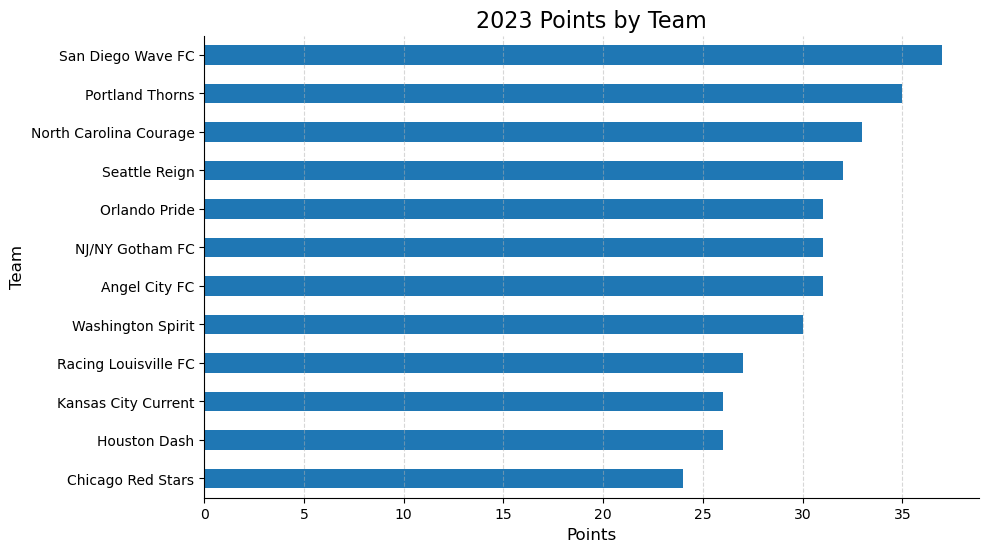

In [952]:
#get some basic frequency data first

import matplotlib.pyplot as plt

df_plot = df_team[['Team','Points']].sort_values(by='Points', ascending=True)

ax = df_plot.plot.barh(x='Team', y='Points', figsize=(10, 6))

# Customize the chart
plt.title('2023 Points by Team', fontsize=16)
plt.xlabel('Points', fontsize=12)
plt.ylabel('Team', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='x', linestyle='--', alpha=0.5)

# Remove spines and legend
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_legend().remove()


# Show the plot
plt.show()

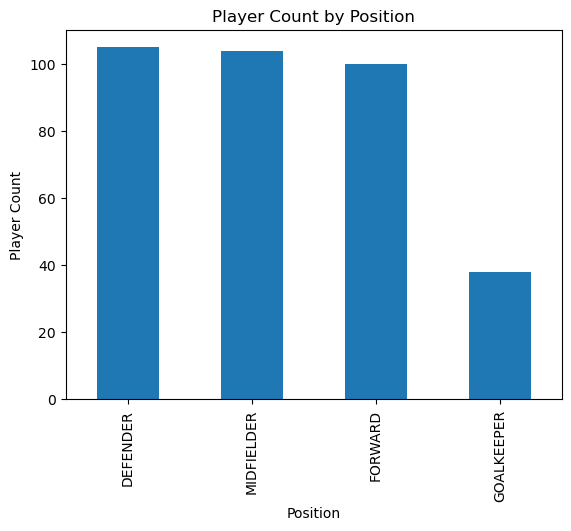

In [953]:
freq = df_player['position'].value_counts()

# Plot the frequencies
freq.plot.bar()
plt.title('Player Count by Position')
plt.xlabel('Position')
plt.ylabel('Player Count')
plt.show()

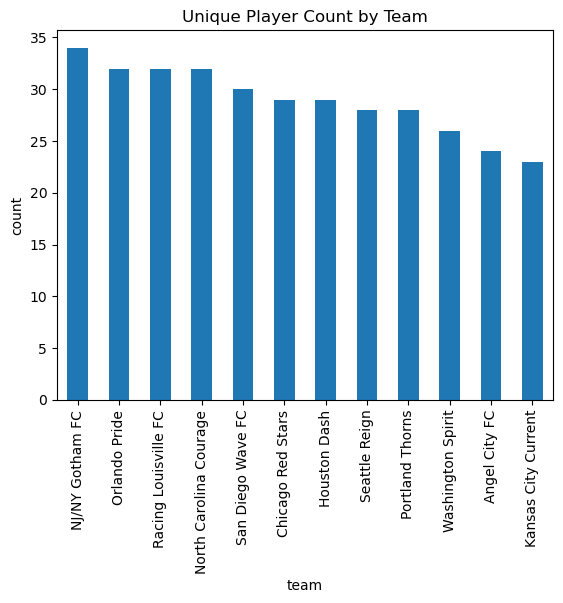

In [954]:
#players by team
freq = df_player['team_corrected'].value_counts().sort_values(ascending=False)
# Plot the frequencies
freq.plot(kind='bar')
plt.xlabel('team')
plt.ylabel('count')
plt.title('Unique Player Count by Team')
plt.show()

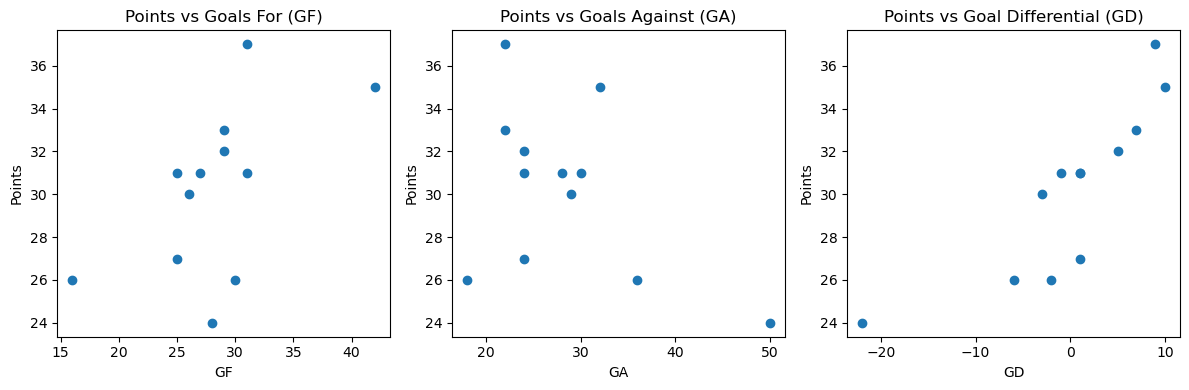

In [955]:
#reminder that Points is what determines the team ranking. You get 3 points for win, 1 point for draw
# team wins vs. goals for (GF) and goals against (GA) and goal differential (GD)
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Plot on the first subplot
axes[0].scatter(df_team['GF'], df_team['Points'])
axes[0].set_title('Points vs Goals For (GF)')
axes[0].set_xlabel('GF')
axes[0].set_ylabel('Points')

# Plot on the second subplot
axes[1].scatter(df_team['GA'], df_team['Points'])
axes[1].set_title('Points vs Goals Against (GA)')
axes[1].set_xlabel('GA')
axes[1].set_ylabel('Points')

# Plot on the third subplot
axes[2].scatter(df_team['GD'], df_team['Points'])
axes[2].set_title('Points vs Goal Differential (GD)')
axes[2].set_xlabel('GD')
axes[2].set_ylabel('Points')

# Show the plot
plt.tight_layout()
plt.show()

Not surprisingly, goal differential seems to have the tightest relationship with points. But that's literally how you win a game, so there's no real insight there. If I had a game-level dataset, I might be better able to assert whether strong offense or strong defense leads to success.

In [957]:
# Let's look at top players in key stats
n=5
col_list0=['minutes_played','goals','on_target_scoring_attempts','assists','goals_and_assists','tackles','interceptions','headed_duel','accurate_passes','fouls_committed','turnovers','saves']
for col in col_list0:
    display(df_player[['player_name','team_corrected','position',col]].nlargest(n, col))


,player_name,team_corrected,position,minutes_played
18,Lauren Barnes,Seattle Reign,DEFENDER,2199
57,Samantha Coffey,Portland Thorns,MIDFIELDER,2080
114,Sarah Gorden,Angel City FC,DEFENDER,2070
334,Christen Westphal,San Diego Wave FC,DEFENDER,2057
168,Kaleigh Kurtz,North Carolina Courage,DEFENDER,2032


,player_name,team_corrected,position,goals
290,Sophia Smith,Portland Thorns,FORWARD,11
156,Kerolin,North Carolina Courage,FORWARD,10
70,Debinha,Kansas City Current,MIDFIELDER,9
125,Ashley Hatch,Washington Spirit,FORWARD,9
335,Lynn Williams,NJ/NY Gotham FC,FORWARD,8


,player_name,team_corrected,position,on_target_scoring_attempts
290,Sophia Smith,Portland Thorns,FORWARD,39
335,Lynn Williams,NJ/NY Gotham FC,FORWARD,37
265,Trinity Rodman,Washington Spirit,FORWARD,31
219,Alexandra Morgan,San Diego Wave FC,FORWARD,29
125,Ashley Hatch,Washington Spirit,FORWARD,26


,player_name,team_corrected,position,assists
57,Samantha Coffey,Portland Thorns,MIDFIELDER,8
26,Julia Bianchi,Chicago Red Stars,MIDFIELDER,5
91,Claire Emslie,Angel City FC,FORWARD,5
219,Alexandra Morgan,San Diego Wave FC,FORWARD,5
255,Megan Anna Rapinoe,Seattle Reign,FORWARD,5


,player_name,team_corrected,position,goals_and_assists
290,Sophia Smith,Portland Thorns,FORWARD,16
156,Kerolin,North Carolina Courage,FORWARD,13
219,Alexandra Morgan,San Diego Wave FC,FORWARD,12
70,Debinha,Kansas City Current,MIDFIELDER,11
125,Ashley Hatch,Washington Spirit,FORWARD,11


,player_name,team_corrected,position,tackles
57,Samantha Coffey,Portland Thorns,MIDFIELDER,46
85,Caprice Dydasco,NJ/NY Gotham FC,DEFENDER,45
215,Narumi Miura,North Carolina Courage,MIDFIELDER,44
232,Jenna Nighswonger,NJ/NY Gotham FC,MIDFIELDER,43
309,Kylie Strom,Orlando Pride,DEFENDER,43


,player_name,team_corrected,position,interceptions
85,Caprice Dydasco,NJ/NY Gotham FC,DEFENDER,45
58,Danielle Colaprico,San Diego Wave FC,MIDFIELDER,39
57,Samantha Coffey,Portland Thorns,MIDFIELDER,38
336,Ryan Williams,North Carolina Courage,DEFENDER,38
48,Gabrielle Carle,Washington Spirit,DEFENDER,36


,player_name,team_corrected,position,headed_duel
335,Lynn Williams,NJ/NY Gotham FC,FORWARD,125
142,Jordyn Huitema,Seattle Reign,FORWARD,119
210,Paige Metayer,Washington Spirit,MIDFIELDER,91
125,Ashley Hatch,Washington Spirit,FORWARD,90
219,Alexandra Morgan,San Diego Wave FC,FORWARD,89


,player_name,team_corrected,position,accurate_passes
168,Kaleigh Kurtz,North Carolina Courage,DEFENDER,1413
336,Ryan Williams,North Carolina Courage,DEFENDER,1238
23,Malia Berkely,North Carolina Courage,DEFENDER,1139
111,Naomi Girma,San Diego Wave FC,DEFENDER,1023
234,Denise O'Sullivan,North Carolina Courage,MIDFIELDER,968


,player_name,team_corrected,position,fouls_committed
295,Emily Sonnett,Seattle Reign,DEFENDER,38
302,Bianca St-Georges,North Carolina Courage,FORWARD,38
125,Ashley Hatch,Washington Spirit,FORWARD,36
56,Mikayla Cluff,Orlando Pride,MIDFIELDER,35
74,Savannah DeMelo,Racing Louisville FC,MIDFIELDER,32


,player_name,team_corrected,position,turnovers
200,Savannah McCaskill,Angel City FC,MIDFIELDER,485
335,Lynn Williams,NJ/NY Gotham FC,FORWARD,440
232,Jenna Nighswonger,NJ/NY Gotham FC,MIDFIELDER,420
309,Kylie Strom,Orlando Pride,DEFENDER,416
242,Carson Pickett,Racing Louisville FC,DEFENDER,407


,player_name,team_corrected,position,saves
46,Jane Campbell,Houston Dash,GOALKEEPER,91.0
187,Katie Lund,Racing Louisville FC,GOALKEEPER,88.0
227,Alyssa Naeher,Chicago Red Stars,GOALKEEPER,80.0
218,Anna Moorhouse,Orlando Pride,GOALKEEPER,72.0
29,Annabella Bixby,Portland Thorns,GOALKEEPER,67.0


In [958]:
# A major question is the role of standout players on a team. It's tough to define 'standout'.
# I'm going to keep it simple and flag a player as standout if they're top k in the league in certain categories
# I'll flag standouts for offense, defense, goalkeeping, and errors (negative standout)
k=10
goalie_k = 5
offense_cols = ['goals','assists','goals_and_assists','accurate_passes']
defense_cols = ['tackles','interceptions']
error_cols = ['turnovers','fouls_committed']

df_player['off_standout'] = (df_player[offense_cols].rank(method='min', ascending=False) <= k).any(axis=1)
df_player['def_standout'] = (df_player[defense_cols].rank(method='min', ascending=False) <= k).any(axis=1)
df_player['gk_standout']= (df_player['saves'].rank(method='min',ascending=False) <=goalie_k)
df_player['err_standout'] = (df_player[error_cols].rank(method='min',ascending=False)<=k).any(axis=1)
#df_player[df_player['err_standout']==True]

In [959]:
#create team level data set to explore relationships with select columns
col_list = ['goals','assists','tackles','accurate_passes','turnovers','saves','fouls_committed','off_standout','def_standout','gk_standout','err_standout']
df_summary = pd.merge(
    df_team[['Team','Points','GF', 'GA', 'GD']], 
    df_player.groupby('team_corrected')[col_list].sum().reset_index(), 
    how='left', 
    left_on='Team', 
    right_on='team_corrected'
)
df_summary.drop('team_corrected',axis=1,inplace=True)
df_summary

,Team,Points,GF,GA,GD,goals,assists,tackles,accurate_passes,turnovers,saves,fouls_committed,off_standout,def_standout,gk_standout,err_standout
0,San Diego Wave FC,37,31,22,9,31,21,218,6934,3445,75.0,227,4,1,1,0
1,Portland Thorns,35,42,32,10,41,29,271,7027,3283,70.0,173,4,1,1,2
2,North Carolina Courage,33,29,22,7,32,24,309,10849,3930,57.0,279,8,3,0,2
3,Seattle Reign,32,29,24,5,29,23,267,7349,3663,70.0,231,5,2,0,1
4,Angel City FC,31,31,30,1,29,23,252,6312,3680,79.0,226,2,0,0,1
5,NJ/NY Gotham FC,31,25,24,1,34,20,371,9735,5208,96.0,334,2,3,0,4
6,Orlando Pride,31,27,28,-1,26,18,287,6232,3306,85.0,236,3,2,1,2
7,Washington Spirit,30,26,29,-3,25,14,239,5308,3274,66.0,249,1,2,0,3
8,Racing Louisville FC,27,25,24,1,26,11,256,7556,3863,88.0,283,1,3,1,3
9,Houston Dash,26,16,18,-2,25,11,214,5715,3261,91.0,216,2,0,1,1


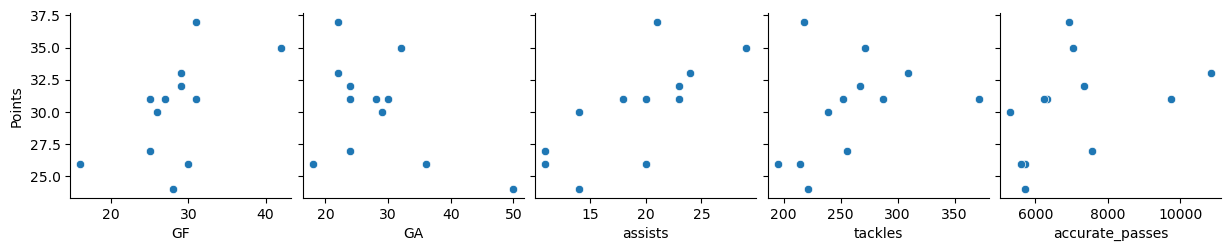

In [960]:
#take a look at scatterplot vs. points, looking for obvious relationships
import seaborn as sns

sns.pairplot(df_summary, x_vars=['GF','GA','assists','tackles','accurate_passes'], y_vars='Points', kind='scatter')
plt.show()
#just eyeballing, the below indicates assists has a somewhat strong positive relationship with points

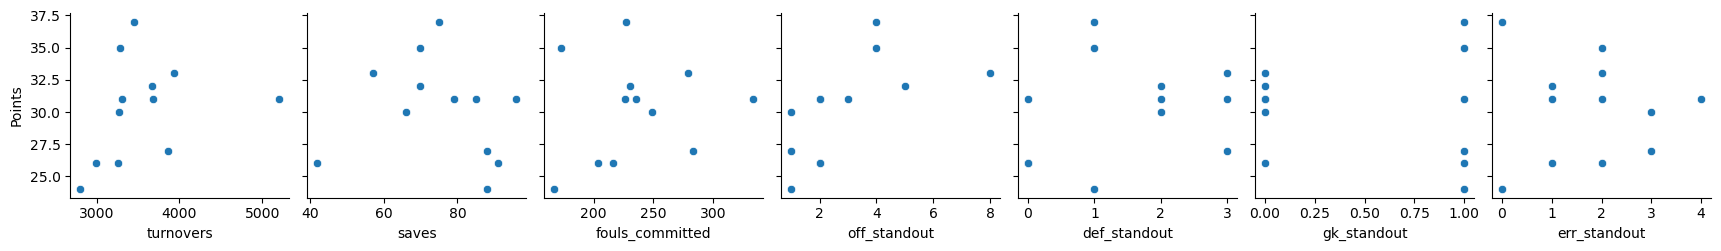

In [961]:
#take a look at scatterplot vs. points for additional columns
import seaborn as sns

sns.pairplot(df_summary, x_vars=['turnovers','saves','fouls_committed','off_standout','def_standout','gk_standout','err_standout'], y_vars='Points', kind='scatter')
plt.show()

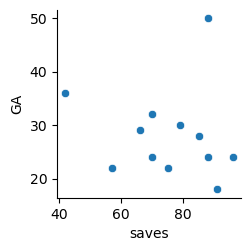

In [962]:
#I'm curious about saves vs. goals against to understand if goalies with a lot of saves are good or they just have a poor defense
sns.pairplot(df_summary, x_vars=['saves'], y_vars='GA', kind='scatter')
plt.show()
#The below has someoutliers but in general, the more saves the fewer goals against, suggesting the goalies with high saves are good.

## Part 3a: Modeling Points
We've done some EDA so now we want to build some models. The first I'd like to try is a linear regression with points as the dependent variable and some of the key stats listed above as independent variables. I realize that some of my features are highly correlated. I also realize I'm picking the wrong "grain" for this analysis. I really should have game-level data that would have a larger sample and more variability, but I couldn't find that anywhere. Regardless, I'm hoping there will be some insights. I'm picking linear regression because I'm less interested in the prediction and more interested in understanding the drivers. I'm not splitting train/validate/test given sample size. I'm also cutting down the variables considered due to sample size. This is quick and dirty.

In [964]:
#Import packages and set up variables
import statsmodels.api as sm

X = df_summary[['GF','GA','assists','accurate_passes','tackles']]
X = sm.add_constant(X)
y = df_summary['Points']

In [965]:
# Fit the model
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 Points   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.649
Method:                 Least Squares   F-statistic:                     5.071
Date:                Sun, 24 Nov 2024   Prob (F-statistic):             0.0365
Time:                        18:40:06   Log-Likelihood:                -22.877
No. Observations:                  12   AIC:                             57.75
Df Residuals:                       6   BIC:                             60.66
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              23.2909      5.885     

/opt/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [966]:
# I'm going to dial back the variables since they aren't showing significance (likely due to sample size)
X2 = df_summary[['GF','GA']]
X2 = sm.add_constant(X2)
y2 = df_summary['Points']
model2= sm.OLS(y2, X2).fit()
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:                 Points   R-squared:                       0.793
Model:                            OLS   Adj. R-squared:                  0.747
Method:                 Least Squares   F-statistic:                     17.26
Date:                Sun, 24 Nov 2024   Prob (F-statistic):           0.000833
Time:                        18:40:06   Log-Likelihood:                -23.344
No. Observations:                  12   AIC:                             52.69
Df Residuals:                       9   BIC:                             54.14
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         24.5782      3.055      8.045      0.0

/opt/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


This model has a very high r-squared and both goals for and goals against are significant contributors to points, with a goal for being more valuable than the negative impact of a goal against. Not exactly earth-shattering. Next time I would try to get game-level data to really understand the contributors to success.

## Part 3b: Clustering Players
The next model that I want to try is to cluster players. I'm curious to compare the analytical findings to my 'gut feel'. I will limit this to the players who had a meaningful number of minutes.

In [969]:
#limiting data set to field players who played at least 1500 min and only the stats features
cluster_col=['player_name','team_corrected','position','minutes_played','goals','assists','accurate_passes','tackles','interceptions','fouls_committed','turnovers']
df_cluster = df_player[
    (df_player['minutes_played'] > 1500) & (df_player['position'] != 'GOALKEEPER')
][cluster_col]
#df_cluster

In [970]:
#import packages and standardize the data
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Standardize the data
scaler = StandardScaler()
df_cluster_dropped = df_cluster.drop(['player_name','position','team_corrected','minutes_played'],axis=1)
df_cluster_scaled = scaler.fit_transform(df_cluster_dropped)

In [971]:
# Initialize and fit the k-means model
k = 6  # will need to revisit the number of clusters in a more thorough review
kmeans = KMeans(n_clusters=k, random_state=99)
kmeans.fit(df_cluster_scaled)

# Add cluster labels back to the original dataset
df_cluster['cluster'] = kmeans.labels_
# show players sorted by cluster
pd.set_option('display.max_rows', None)
df_cluster.sort_values('cluster',ascending=True)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,player_name,team_corrected,position,minutes_played,goals,assists,accurate_passes,tackles,interceptions,fouls_committed,turnovers,cluster
202,Haley McCutcheon,Orlando Pride,DEFENDER,1955,1,0,513,33,18,18,325,0
212,Tatumn Milazzo,Chicago Red Stars,DEFENDER,1787,1,1,679,30,22,20,334,0
72,Kathryn Del Fava,Kansas City Current,DEFENDER,1829,0,1,621,18,27,24,305,0
269,Yazmeen Ryan,NJ/NY Gotham FC,MIDFIELDER,1831,2,1,556,20,20,23,381,0
63,Michelle Cooper,Kansas City Current,FORWARD,1634,3,1,330,26,10,28,316,0
278,Sophie Schmidt,Houston Dash,MIDFIELDER,1720,0,0,558,29,26,25,304,0
264,Cari Roccaro,Chicago Red Stars,MIDFIELDER,1830,1,0,653,27,22,21,182,0
295,Emily Sonnett,Seattle Reign,DEFENDER,1947,0,1,747,31,26,38,260,0
311,Andi Sullivan,Washington Spirit,MIDFIELDER,1706,0,0,489,27,27,27,201,0
302,Bianca St-Georges,North Carolina Courage,FORWARD,1574,4,1,410,23,17,38,326,0


In [972]:
# let's get some average stats on the clusters
df_cluster.groupby('cluster',as_index=False)[['goals','assists','accurate_passes','tackles','interceptions','fouls_committed','turnovers']].mean()

,cluster,goals,assists,accurate_passes,tackles,interceptions,fouls_committed,turnovers
0,0,1.272727,0.636364,547.272727,27.454545,21.727273,27.000000,282.909091
1,1,3.000000,1.285714,435.714286,14.428571,10.285714,14.714286,257.000000
2,2,0.285714,0.071429,780.714286,13.714286,24.071429,8.428571,181.857143
3,3,0.700000,2.000000,723.300000,39.200000,32.700000,19.000000,341.000000
4,4,6.615385,3.000000,358.769231,16.153846,10.384615,22.230769,344.384615
5,5,0.500000,1.500000,856.833333,18.666667,27.166667,14.333333,326.000000


In [973]:
pd.crosstab(df_cluster['cluster'], df_cluster['position'])

position,DEFENDER,FORWARD,MIDFIELDER
cluster,,,
0,4,2,5
1,1,3,3
2,13,0,1
3,5,0,5
4,0,9,4
5,11,1,0


Here are my descriptions of the clusters:
* 0 - some offense but most known for errors like fouls and turnovers. Spread across positions.
* 1 - strong offense, limited passing and defense. Spread across FWD MID.
* 2 - limited offense, few errors; accurate passes DEF
* 3 - playmakers - lots of assists, tackles, passes, interceptions; MID and DEF
* 4 - scorers and also high assists - FWD and MID
* 5 - not huge standouts anywhere, mainly DEF

In [975]:
#Let's look at a few of the outliers
# Forwards in Cluster 0
df_cluster[(df_cluster['cluster']==0) & (df_cluster['position']=='FORWARD')]

,player_name,team_corrected,position,minutes_played,goals,assists,accurate_passes,tackles,interceptions,fouls_committed,turnovers,cluster
63,Michelle Cooper,Kansas City Current,FORWARD,1634,3,1,330,26,10,28,316,0
302,Bianca St-Georges,North Carolina Courage,FORWARD,1574,4,1,410,23,17,38,326,0


In [976]:
# Defenders in Cluster 1
df_cluster[(df_cluster['cluster']==1) & (df_cluster['position']=='DEFENDER')]

,player_name,team_corrected,position,minutes_played,goals,assists,accurate_passes,tackles,interceptions,fouls_committed,turnovers,cluster
165,Casey Krueger,Chicago Red Stars,DEFENDER,1711,0,2,525,18,12,12,283,1


In [977]:
# Defenders in Cluster 2
df_cluster[(df_cluster['cluster']==2) & (df_cluster['position']=='MIDFIELDER')]

,player_name,team_corrected,position,minutes_played,goals,assists,accurate_passes,tackles,interceptions,fouls_committed,turnovers,cluster
58,Danielle Colaprico,San Diego Wave FC,MIDFIELDER,1826,0,1,545,15,39,20,183,2


In [978]:
# Defenders in Cluster 4
df_cluster[(df_cluster['cluster']==4) & (df_cluster['position']=='MIDFIELDER')]

,player_name,team_corrected,position,minutes_played,goals,assists,accurate_passes,tackles,interceptions,fouls_committed,turnovers,cluster
70,Debinha,Kansas City Current,MIDFIELDER,1526,9,2,394,11,10,13,336,4
74,Savannah DeMelo,Racing Louisville FC,MIDFIELDER,1588,5,2,361,20,8,32,318,4
200,Savannah McCaskill,Angel City FC,MIDFIELDER,1962,4,3,630,17,4,17,485,4
331,Morgan Weaver,Portland Thorns,MIDFIELDER,1905,7,4,314,12,6,14,386,4


In [979]:
# Defenders in Cluster 4
df_cluster[(df_cluster['cluster']==5) & (df_cluster['position']=='FORWARD')]

,player_name,team_corrected,position,minutes_played,goals,assists,accurate_passes,tackles,interceptions,fouls_committed,turnovers,cluster
205,Tara McKeown,Washington Spirit,FORWARD,1833,1,1,801,19,35,17,257,5


## Reflections
I learned a lot working through this. Since my main goal was to practice Python, I would deem it a success. But there are things I should have done differently in retrospect. I should have spent time reading papers about similar analyses. While there's little out there on NWSL, there's undoubtedly a trove of work on men's soccer. I also should have been more skeptical about the data. I found major issues with the data on Kaggle and even the data on the NWSL website. I spent an absurd about of time manually fixing the team assignments. As mentioned previously, I really needed finer grain data if I wanted to model points (or wins). I also should have more carefully thought through what I wanted to model before launching in. My visualizations are somewhat random and elementary. Professional visualizations with consistent look and feel, thorough labeling, and logical colors make a big difference with the audience. Finally, I didn't spend much time on the modeling, given the focus of this class, the nature of the assignment, and my available time. A real project, of course, would demand a more thorough approach: train/test split, feature engineering, parameter tuning, etc. 